In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch
import torch.nn.functional as F


from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.trainer import Tester
from utils.trainer import Trainer
from datetime import datetime


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()
device

device(type='cuda', index=0)

In [4]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
hidden_size = 2500
mogrify_rounds = 5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [5]:
import xarray as xr
data_path = '../../../data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...


In [6]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2, cut_y=True)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [7]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([8376, 1, 5, 50, 50])
Y :  torch.Size([8376, 1, 50, 50])
-----Val-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 50, 50])
-----Test-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 50, 50])


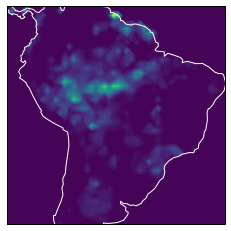

In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.x[0, 0, 4, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [9]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [10]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

In [11]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [12]:
class CustomConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
        self.padding = [kernel_size // 2, kernel_size // 2]
        
    def forward(self,input, weight=None):
        if (weight is not None):
            return F.conv2d(input, weight.permute(1,0,2,3), self.bias, self.stride,
                        self.padding, self.dilation)
        else:
            return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [13]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, device):
        super(EncoderCNN, self).__init__()
        self.device = device
        self.layer_size = layer_size
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.decode_bn_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(self.layer_size):
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.decode_bn_layers.append(torch.nn.BatchNorm2d(in_channels))
            self.dropout_layers.append(torch.nn.Dropout(dropout_rate))
            in_channels = out_channels
            
        self.conv_reduce = CustomConv2d(in_channels = in_channels, out_channels = 1,
                                                kernel_size = 1)
            
            
    def forward(self, x, decode=False):
        if (decode):
            x = self.conv_reduce(x, self.conv_reduce.weight)
            for i in range(self.layer_size-1, -1, -1):
                x = self.conv_layers[i](x, self.conv_layers[i].weight)
                x = self.decode_bn_layers[i](x)
                x = self.mish_layers[i](x)
                x = self.dropout_layers[i](x)
        else:
            for i in range(self.layer_size):
                x = self.conv_layers[i](x)
                x = self.bn_layers[i](x)
                x = self.mish_layers[i](x)
                x = self.dropout_layers[i](x)
            x = self.conv_reduce(x)
        return x

In [14]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, kernel_size, out_channels, in_channels, input_width, input_height, hidden_size
                 , device):
        super(STModel, self).__init__()
        self.device = device
        self.encoder = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, device=device)
        self.recurrent_encoder = torch.nn.LSTMCell(input_width*input_height, hidden_size);
        #self.recurrent_decoder = torch.nn.LSTMCell(input_width*input_height, hidden_size);
       
        
    def forward(self, x, states):
        batch, channel, time, lat, lon = x.size()
        x = x.view(batch*time, channel, lat, lon)
        x = self.encoder(x)
        
        x = x.view(batch, time, -1)
        h = states[0]
        c = states[1]
        for i in range(time):
            h,c = self.recurrent_encoder(x[:,i,:],(h,c))
            
        x = h.contiguous().view(batch, channel, lat, lon)
        x = self.encoder(x, decode=True)
        return x.view(batch, channel, lat, lon)
        

In [15]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [16]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], 
                input_height = train_data.x.shape[4], hidden_size = hidden_size, device=device).to(device)
criterion = RMSELoss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (1): CustomConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (2): CustomConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
    )
    (mish_layers): ModuleList(
      (0): Mish()
      (1): Mish()
      (2): Mish()
    )
    (bn_layers): ModuleList(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (decode_bn_layers): ModuleList(
      (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(32, ep

In [17]:
model_path = os.path.join('../../../models/CHIRPS/1_step/STModel' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, cut_output=True, recurrent_model =  True, patience=5)


In [18]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 7.111175
Val Avg. Loss: 7.044222
=> Saving a new best
Train - Epoch 1, Epoch Loss: 6.950638
Val Avg. Loss: 6.899424
=> Saving a new best
Train - Epoch 2, Epoch Loss: 6.806300
Val Avg. Loss: 6.777742
=> Saving a new best
Train - Epoch 3, Epoch Loss: 6.664676
Val Avg. Loss: 6.772792
=> Saving a new best
Train - Epoch 4, Epoch Loss: 6.494202
Val Avg. Loss: 6.513143
=> Saving a new best
Train - Epoch 5, Epoch Loss: 6.318187
Val Avg. Loss: 6.383608
=> Saving a new best
Train - Epoch 6, Epoch Loss: 6.113161
Val Avg. Loss: 6.354380
=> Saving a new best
Train - Epoch 7, Epoch Loss: 5.935671
Val Avg. Loss: 6.314822
=> Saving a new best
Train - Epoch 8, Epoch Loss: 5.775956
Val Avg. Loss: 6.278922
=> Saving a new best
Train - Epoch 9, Epoch Loss: 5.645427
Val Avg. Loss: 6.236006
=> Saving a new best
Train - Epoch 10, Epoch Loss: 5.558495
Val Avg. Loss: 6.228271
=> Saving a new best
Train - Epoch 11, Epoch Loss: 5.451428
Val Avg. Loss: 6.188962
=> Saving a new best
Tr

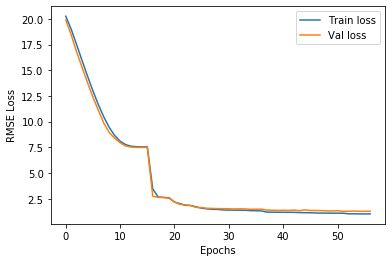

In [20]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [19]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

trainer.path = '../../../models/CHIRPS/1_step/STModel_m04d14-h16m20s04.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        batch_test_loss += loss.detach().item()
test_loss = batch_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S RMSELoss: 6.1193


In [21]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

trainer.path = '../../../models/CHIRPS/1_step/STModel_m05d06-h13m12s06.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
previous_three_steps = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        for j in range(2,5):
            previous_three_steps.append(x[24,0,j,:,:])
        x,y = x.to(device), y.to(device)
        ground_truth = y[24,0,:,:]
        states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        prediction = output[24,0,:,:]
        print(criterion(prediction, ground_truth))
        break

tensor(3.6633, device='cuda:0')


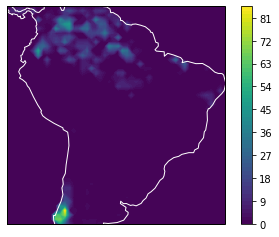

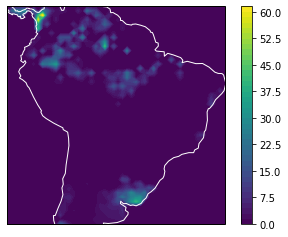

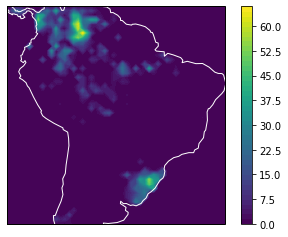

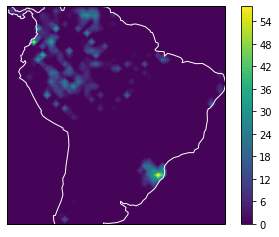

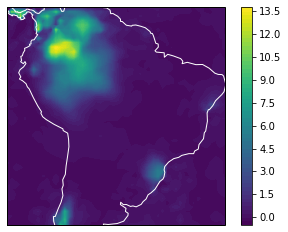

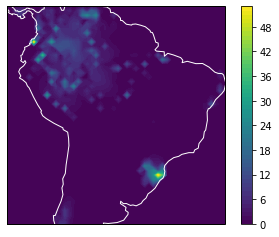

In [22]:
sst = previous_three_steps[0]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.plot(color='white')
plt.colorbar()
plt.show()

sst = previous_three_steps[1]
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.colorbar()
plt.show()

sst = previous_three_steps[2]
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.colorbar()
plt.show()

sst = ground_truth.cpu()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.colorbar()
plt.show()

sst = prediction.cpu()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.colorbar()
plt.show()

fig, ax = plt.subplots()
sst = abs(ground_truth-prediction).cpu()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')
plt.colorbar()
plt.show()
